In [62]:
### 분석에 필요한 라이브러리 입니다.
### 그대로 복붙하셔서 사용해주세요

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [3]:
df = pd.read_csv('Pizza Sales Dataset.csv')
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_day,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,Thursday,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,Thursday,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,Thursday,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
df.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_day', 'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')

### 컬럼명 한국어로 바꾸기

In [5]:
df.rename(columns={
    'pizza_id': '피자 ID',
    'order_id': '주문 ID',
    'pizza_name_id': '피자 이름 ID',
    'quantity': '주문 수량',
    'order_date': '주문 날짜',
    'order_day': '주문 요일',
    'order_time': '주문 시간',
    'unit_price': '단가',
    'total_price': '총액',
    'pizza_size': '피자 사이즈',
    'pizza_category': '피자 종류',
    'pizza_ingredients': '피자 재료 목록',
    'pizza_name': '피자 이름'
}, inplace=True)

In [6]:
# 결측치 확인 : 없음
df.isna().sum()

피자 ID       0
주문 ID       0
피자 이름 ID    0
주문 수량       0
주문 날짜       0
주문 요일       0
주문 시간       0
단가          0
총액          0
피자 사이즈      0
피자 종류       0
피자 재료 목록    0
피자 이름       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   피자 ID     48620 non-null  int64  
 1   주문 ID     48620 non-null  int64  
 2   피자 이름 ID  48620 non-null  object 
 3   주문 수량     48620 non-null  int64  
 4   주문 날짜     48620 non-null  object 
 5   주문 요일     48620 non-null  object 
 6   주문 시간     48620 non-null  object 
 7   단가        48620 non-null  float64
 8   총액        48620 non-null  float64
 9   피자 사이즈    48620 non-null  object 
 10  피자 종류     48620 non-null  object 
 11  피자 재료 목록  48620 non-null  object 
 12  피자 이름     48620 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 4.8+ MB


### 분석 시작(팀 전체 분석 향목)

### 1. ⏰ **시간대별 주문량 분석 (피크타임 파악) 혜원님**

- **목표**: 언제 사람들이 피자를 가장 많이 먹는가?
- **시각화**: `order_hour` 기준 막대 그래프
- **활용**: 매장 인력 운영, 프로모션 타이밍 설계

---

### 2. 📅 **요일별 주문량 분석 (주말 특수 여부) 혜원님**

- **목표**: 피자 수요는 주중 vs 주말 어떻게 다른가?
- **시각화**: `order_day` 기준 막대 그래프
- **활용**: 주말 집중 마케팅 or 할인 전략 근거

---

### 3. 🍕 **피자 종류별 판매량 TOP 10 혜원님**

- **목표**: 어떤 피자가 잘 팔리는가?
- **시각화**: `pizza_name` 기준 상위 판매량 그래프
- **활용**: 메뉴 구성 / 베스트 메뉴 강조 포스터 설계

---

### 4. 🧂 **토핑 재료 수와 주문량 관계 효준님**

- **목표**: 재료가 많은 피자가 더 잘 팔릴까?
- **전처리**: `pizza_ingredients`에서 재료 수 추출
- **시각화**: 재료 개수 vs 평균 주문량 선 그래프
- **활용**: 고급형 메뉴 개발 or 단순 메뉴 확대 결정

---

### 5. 💰 **단가 대비 판매량 분석 효준님**

- **목표**: 고가 피자가 더 많이 팔릴까?
- **시각화**: `unit_price` vs `quantity` 산점도
- **활용**: 프리미엄 라인 확대 or 중저가 전략 고민

---

### 6. 📐 **사이즈별 판매 비중 분석 효준님**

- **목표**: 고객은 어떤 크기의 피자를 선호하는가?
- **시각화**: `pizza_size` 비율 파이차트 or 막대차트
- **활용**: 프로모션 세트 구성 / 소형 메뉴 도입 판단

---

### 7. 📊 **카테고리별 주문량 비교 (Classic / Gourmet / Veg 등) 효준님**

- **목표**: 채식 피자의 수요는 존재하는가?
- **시각화**: `pizza_category` 기준 막대그래프
- **활용**: 고객군 타깃 세분화, 건강식 피자 출시 판단

---

### **8. 🍕주문 ID가 같은 사용자 중(한번에 여러판 주문) 같이 주문하는 피자의 조합 중 BEST 3를 뽑아보자. 수연님**

> 세트 메뉴로 구성해서 단가를 낮춰보자.
> 

---

### **9. ☀️주문 날짜(계절별(3,4,5/6,7,8/9,10,11/12,1,2)) 주문을 많이 하는 계절별로 주문량이 많은 메뉴 TOP5를 골라보자.** 현석님

> 시즌메뉴를 구성해보자.
> 

---

### **10.💭 피자 주문 조합 BEST3를 조사해보자. Ex. 한번 주문 시, 스몰사이즈로 여러가지 종류의 피자를 주문 VS 같은 종류로 여러판 구매** 설연님

> 콤보 메뉴를 만들기.
> 

---

### **11. 🧑‍🧑‍🧒단체 주문(3판 이상)이 많을 까 아니면 소규모 주문(1,2판)이 많을까? 설연님**

> 소규모 주문이 믾거나 단체주문이 많을 때 각각의 경우 할인 이벤트를 구성.
> 

---

### **12. 🌇평일 VS 휴일(토,일,공휴일) 중 주문량과 매출액을 비교 설연님**

> 주말 할인, 특정 날(어린이날, 커플의 날)에 할인(이미 하고 있음.)
> 

---

### 13. 🥣점심 주문이 많나 저녁 주문이 많나? 현석님

(오픈시간 중 주문량이 적은 시간에 할인 이벤트로 주문 유도)

마찬가지로 통계적으로 주문이 적은 요일에 할인이벤트로 주문 유도

---

### **14. 🔄 피자 크기 조합 분석 – 어떤 사이즈 조합이 자주 같이 팔릴까? 현석님**

- **목표**: 한 주문 안에서 어떤 사이즈 조합이 자주 등장하는가?
- **전처리**: `Order ID`별 `Size` 조합 분석
- **시각화**: 크기 조합별 빈도수 히트맵
- **활용**: 세트 구성 최적화 (예: M + L 구성 세트 메뉴)

---

### **15. 🔄 재구매 추정 (동일 Order ID 빈도 기반)**

- **목표**: 고객들은 어떤 가격대 + 어떤 종류의 피자를 즐기는가?
- **시각화**: `unit_price`, `category`, `size` 기준 버블 차트
- **활용**: 타깃 고객별 맞춤 프로모션 (ex. 저가+소형 선호 고객층 vs 고가+XL 고객층)

---

### **16.  🧄**토핑 종류 다양성과 단가 관계 분석 수연님

- 목표: 토핑이 많을수록 가격이 비쌀까?
- 전처리: Toppings 개수 계산 → Unit Price와 관계 산점도
- 활용: 토핑 추가 가격 정책 검토

### 현석 담당의 분석 항목 : 9, 13, 14번

### **9. ☀️주문 날짜(계절별(3,4,5/6,7,8/9,10,11/12,1,2)) 주문을 많이 하는 계절별로 주문량이 많은 메뉴 TOP5를 골라보자.** 현석님

시즌메뉴를 구성해보자.

---

In [17]:
#년/월/일 순으로 바꾸기 위해 datetime type으로 자료형을 바꾼다.
df['주문 날짜'] = pd.to_datetime(df['주문 날짜'], dayfirst=True, errors='raise')

In [18]:
#데이터 타입이 datetime64[ns]여야함.
print(df['주문 날짜'].dtype)

datetime64[ns]


In [19]:
# 년/월/일 순으로 바꾼다.
df['주문 날짜'] = df['주문 날짜'].dt.strftime('%Y/%m/%d')


In [28]:
# 월 정보를 추출하는 칼럼을 생성한다.
df['월'] = df['주문 날짜'].str.slice(5, 7).astype(int)

In [32]:
# 월 정보를 분기로 나눈다.
def 분기_3개월(month):
    if month in [3, 4, 5]:
        return '봄(3~5월)'
    elif month in [6, 7, 8]:
        return '여름(6~8월)'
    elif month in [9, 10, 11]:
        return '가을(9~11월)'
    else:  # 12, 1, 2
        return '겨울(12~2월)'

df['분기'] = df['월'].apply(분기_3개월)

In [58]:
# 분기별 피자이름의 주문 수량 합계
분기별_피자이름_합계 = (
    df.groupby(['분기', '피자 이름'])['주문 수량']
      .sum()
      .reset_index(name='총주문수량')
      .sort_values(['분기', '총주문수량'], ascending=[True, False]))

In [61]:
#TOP5만 구해본다.
top5_분기별_피자이름 = (
    분기별_피자이름_합계
    .groupby('분기')
    .head(5)
    .reset_index(drop=True)
)

print(top5_분기별_피자이름)

           분기                         피자 이름  총주문수량
0   가을(9~11월)      The Classic Deluxe Pizza    629
1   가을(9~11월)            The Hawaiian Pizza    612
2   가을(9~11월)    The Barbecue Chicken Pizza    604
3   가을(9~11월)        The Thai Chicken Pizza    596
4   가을(9~11월)           The Pepperoni Pizza    589
5   겨울(12~2월)  The California Chicken Pizza    605
6   겨울(12~2월)           The Pepperoni Pizza    601
7   겨울(12~2월)    The Barbecue Chicken Pizza    594
8   겨울(12~2월)      The Classic Deluxe Pizza    575
9   겨울(12~2월)            The Hawaiian Pizza    571
10    봄(3~5월)    The Barbecue Chicken Pizza    639
11    봄(3~5월)            The Hawaiian Pizza    635
12    봄(3~5월)      The Classic Deluxe Pizza    630
13    봄(3~5월)        The Thai Chicken Pizza    610
14    봄(3~5월)           The Pepperoni Pizza    608
15   여름(6~8월)  The California Chicken Pizza    622
16   여름(6~8월)           The Pepperoni Pizza    620
17   여름(6~8월)      The Classic Deluxe Pizza    619
18   여름(6~8월)            The Ha

In [135]:
#TOP10만 구해본다.
top10_분기별_피자이름 = (
    분기별_피자이름_합계
    .groupby('분기')
    .head(20)
    .reset_index(drop=True)
)

print(top10_분기별_피자이름)

           분기                                       피자 이름  총주문수량
0   가을(9~11월)                    The Classic Deluxe Pizza    629
1   가을(9~11월)                          The Hawaiian Pizza    612
2   가을(9~11월)                  The Barbecue Chicken Pizza    604
3   가을(9~11월)                      The Thai Chicken Pizza    596
4   가을(9~11월)                         The Pepperoni Pizza    589
..        ...                                         ...    ...
75   여름(6~8월)                       The Five Cheese Pizza    380
76   여름(6~8월)            The Prosciutto and Arugula Pizza    380
77   여름(6~8월)           The Vegetables + Vegetables Pizza    373
78   여름(6~8월)                 The Italian Capocollo Pizza    359
79   여름(6~8월)  The Pepperoni, Mushroom, and Peppers Pizza    358

[80 rows x 3 columns]


In [56]:
a1 = df['피자타입'].nunique()
a2 = df['피자 이름'].nunique()
a3 = df['피자 종류'].nunique()
print(a1,a2,a3)

32 32 4


In [136]:
top10_분기별_피자이름.to_csv('분기별피자자_Top10.csv', index=False, encoding='utf-8-sig')

TOP5에서 TOP10으로 항목을 간추려도 큰 변화가 없다. 시즌메뉴는 필요 없을 것 같다.

### 13. 🥣점심 주문이 많나 저녁 주문이 많나? 현석님

(오픈시간 중 주문량이 적은 시간에 할인 이벤트로 주문 유도)

마찬가지로 통계적으로 주문이 적은 요일에 할인이벤트로 주문 유도

---

In [124]:
print(df['주문 시간'].dtype)

object


In [125]:
# 1. 시간 형식으로 변환 (시간만 있는 경우 'datetime.time' 형태로 변환 가능)
df['주문 시간 변환'] = pd.to_datetime(df['주문 시간'], format='%H:%M:%S').dt.time

# 2. 변환한 시간 기준으로 정렬
df_sorted = df.sort_values(by='주문 시간 변환')

# 3. 정렬 결과 확인
print(df_sorted)

       피자 ID  주문 ID        피자 이름 ID  주문 수량       주문 날짜     주문 요일     주문 시간  \
43612  43613  19176      hawaiian_l      1  2015/11/24   Tuesday   9:52:21   
43613  43614  19176  peppr_salami_l      1  2015/11/24   Tuesday   9:52:21   
43614  43615  19176    the_greek_xl      1  2015/11/24   Tuesday   9:52:21   
43615  43616  19176    veggie_veg_l      1  2015/11/24   Tuesday   9:52:21   
34189  34190  15092     pepperoni_m      1  2015/10/09  Thursday  10:25:19   
...      ...    ...             ...    ...         ...       ...       ...   
7096    7097   3133   soppressata_l      1  2015/02/21  Saturday  23:05:24   
7095    7096   3133    napolitana_l      1  2015/02/21  Saturday  23:05:24   
7094    7095   3133  mediterraneo_l      1  2015/02/21  Saturday  23:05:24   
28219  28220  12433  spinach_supr_m      1  2015/07/26    Sunday  23:05:52   
28220  28221  12433    veggie_veg_m      1  2015/07/26    Sunday  23:05:52   

          단가     총액 피자 사이즈    피자 종류  \
43612  16.50  16.50     

오전 주문도 존재하므로 시간대를 아침 : 9시부터 11시이전,점심 : 11시부터 3시이전,브레이크타임 : 3시부터 5시이전,저녁 : 5시부터 9시이전,야간 : 9시부터 12시이전으로 나누어본다.

In [126]:
#datetime type으로 변환
df['주문 시간 변환'] = pd.to_datetime(df['주문 시간'], format='%H:%M:%S', errors='coerce').dt.hour

In [127]:
#시간대 칼럼을 생성성
def 시간대(hour):
    if 9 <= hour < 11:
        return '아침'
    elif 11 <= hour < 15:
        return '점심'
    elif 15 <= hour < 17:
        return '브레이크타임'
    elif 17 <= hour < 21:
        return '저녁'
    elif 21 <= hour < 24:
        return '야간'
    else:
        return '기타'  # 예: 0~8시 또는 결측치 처리

df['시간대'] = df['주문 시간 변환'].apply(시간대)

In [128]:
df.groupby('시간대').size().reset_index(name='주문수')

,시간대,주문수
0,브레이크타임,7355
1,아침,21
2,야간,3966
3,저녁,18339
4,점심,18939


아침(9-11)에는 주문 수가 거의 없고
점심(11-3),저녁(5-9) 주문량이 최대
브레이크타임(3-5) 주문량이 점심, 저녁의 약 40퍼센트인데 이는 시간 간격상 때문일 수도 있으므로
다시 1시간 간격으로 조사한다.

In [129]:
#9시부터 23시까지 필터링 (23시~24시 구간을 위해 23까지 포함)
df_valid = df[df['주문 시간 변환'].between(9, 23)].copy()

#시작시간 라벨 생성
df_valid['시간대'] = df_valid['주문 시간 변환'].astype(str) + '시~' + (df_valid['주문 시간 변환'] + 1).astype(str) + '시'

#시간대별 개수 세기
시간대별_개수 = (
    df_valid['시간대']
    .value_counts()
    .reset_index()
    .rename(columns={'index': '시간대', '시간대': '개수'})
)

#시간대 문자열을 기준으로 정렬하기 위해 시작시간 숫자 추출
시간대별_개수['시작시간'] = 시간대별_개수['시간대'].str.split('시').str[0].astype(int)

#시작시간 기준 오름차순 정렬 후 필요 없는 컬럼 삭제
시간대별_개수 = 시간대별_개수.sort_values('시작시간').drop(columns='시작시간').reset_index(drop=True)

#출력
print(시간대별_개수)

        시간대    개수
0    9시~10시     4
1   10시~11시    17
2   11시~12시  2672
3   12시~13시  6543
4   13시~14시  6203
5   14시~15시  3521
6   15시~16시  3170
7   16시~17시  4185
8   17시~18시  5143
9   18시~19시  5359
10  19시~20시  4350
11  20시~21시  3487
12  21시~22시  2528
13  22시~23시  1370
14  23시~24시    68


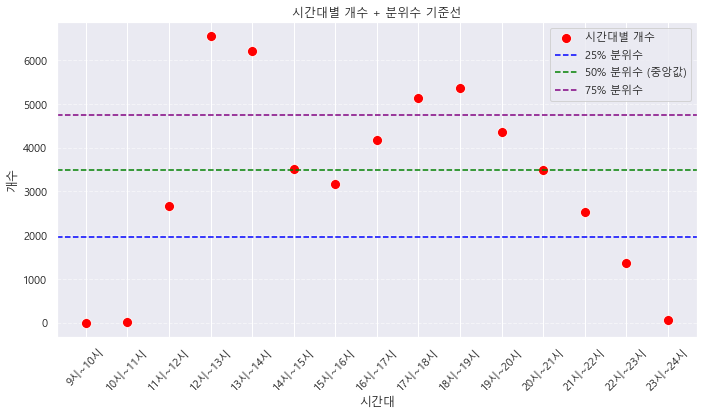

In [130]:
# 분위수 계산
q25 = 시간대별_개수['개수'].quantile(0.25)
q50 = 시간대별_개수['개수'].quantile(0.50)
q75 = 시간대별_개수['개수'].quantile(0.75)

plt.figure(figsize=(10, 6))

# 시간대별 개수를 점으로 시각화
sns.scatterplot(x='시간대', y='개수', data=시간대별_개수, s=100, color='red', label='시간대별 개수')

# 분위수 기준선 추가
plt.axhline(q25, color='blue', linestyle='--', label='25% 분위수')
plt.axhline(q50, color='green', linestyle='--', label='50% 분위수 (중앙값)')
plt.axhline(q75, color='purple', linestyle='--', label='75% 분위수')

# 시각적 요소 설정
plt.title('시간대별 개수 + 분위수 기준선')
plt.xlabel('시간대')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 11-12 : 점심시간 전 1시간으로 점심시간 진입 구간 >> 주문량 서서히 증가
### 15-16(오후3시-4시) : 점심시간 끝난 후 1시간으로 >> 주문량 서서히 감소 - 할인행사 해볼법하지만 주문량은 중앙값에 가까움.
### 21-23(오후9시~11시) : 주문량이 감소하였고 중앙값에 한참 모자람. 야식 시간이므로 이 때 주문량 증가를 위해 할인이벤트를 해볼만함.

In [131]:
# 시간대별_개수 DataFrame을 CSV 파일로 저장
시간대별_개수.to_csv('시간대별_주문수.csv', index=False, encoding='utf-8-sig')

### **14. 🔄 피자 크기 조합 분석 – 어떤 사이즈 조합이 자주 같이 팔릴까? 현석님**

- **목표**: 한 주문 안에서 어떤 사이즈 조합이 자주 등장하는가?
- **전처리**: `Order ID`별 `Size` 조합 분석
- **시각화**: 크기 조합별 빈도수 히트맵
- **활용**: 세트 구성 최적화 (예: M + L 구성 세트 메뉴)

---

In [92]:
df

,피자 ID,주문 ID,피자 이름 ID,주문 수량,주문 날짜,주문 요일,주문 시간,단가,총액,피자 사이즈,피자 종류,피자 재료 목록,피자 이름,월,피자타입,분기,주문 시간 변환,시간대
0,1,1,hawaiian_m,1,2015/01/01,Thursday,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,1,Classic The Hawaiian Pizza,겨울(12~2월),11,11시~12시
1,2,2,classic_dlx_m,1,2015/01/01,Thursday,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,1,Classic The Classic Deluxe Pizza,겨울(12~2월),11,11시~12시
2,3,2,five_cheese_l,1,2015/01/01,Thursday,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,1,Veggie The Five Cheese Pizza,겨울(12~2월),11,11시~12시
3,4,2,ital_supr_l,1,2015/01/01,Thursday,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,1,Supreme The Italian Supreme Pizza,겨울(12~2월),11,11시~12시
4,5,2,mexicana_m,1,2015/01/01,Thursday,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,1,Veggie The Mexicana Pizza,겨울(12~2월),11,11시~12시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015/12/31,Thursday,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,12,Chicken The Chicken Alfredo Pizza,겨울(12~2월),21,21시~22시
48616,48617,21348,four_cheese_l,1,2015/12/31,Thursday,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,12,Veggie The Four Cheese Pizza,겨울(12~2월),21,21시~22시
48617,48618,21348,napolitana_s,1,2015/12/31,Thursday,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,12,Classic The Napolitana Pizza,겨울(12~2월),21,21시~22시
48618,48619,21349,mexicana_l,1,2015/12/31,Thursday,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,12,Veggie The Mexicana Pizza,겨울(12~2월),22,22시~23시


주문 조합을 보기 앞서서 몇개를 한번에 주문하는 지 빈도를 파악한다.

In [113]:
# 주문 ID별 피자 사이즈 리스트(정렬 포함)
피자사이즈_조합 = df.groupby('주문 ID')['피자 사이즈'].apply(list).reset_index()

# 조합 내 총 피자 개수 (중복 포함)
피자사이즈_조합['조합개수'] = 피자사이즈_조합['피자 사이즈'].apply(len)

# 조합 문자열 생성 (보기 쉽게)
피자사이즈_조합['조합문자열'] = 피자사이즈_조합['피자 사이즈'].apply(lambda x: ','.join(sorted(x)))

# 조합개수별 빈도수 계산
빈도_조합개수 = 피자사이즈_조합.groupby('조합개수').size().reset_index(name='빈도수')

print(빈도_조합개수)

    조합개수   빈도수
0      1  8201
1      2  6196
2      3  3325
3      4  2888
4      5   144
5      6    75
6      7    75
7      8    83
8      9    65
9     10    59
10    11    69
11    12    71
12    13    52
13    14    38
14    15     7
15    21     2


1개 주문이 제일 많고 그다음 2,3,4개가 뒤를 따른다.

우선 전체 조합에서 TOP10을 가져온다.

In [108]:
# 1. 주문 ID별 피자 사이즈 리스트를 정렬하여 문자열로 결합 (순서 무시)
피자사이즈_조합 = df.groupby('주문 ID')['피자 사이즈'].apply(lambda x: ','.join(sorted(x))).reset_index(name='사이즈조합')

# 2. 조합별 빈도수 세기
조합_빈도 = (
    피자사이즈_조합['사이즈조합']
    .value_counts()
    .reset_index()
    .rename(columns={'index': '사이즈조합', '사이즈조합': '빈도수'})
    .head(10)
)

# 3. 결과 출력
print(조합_빈도)

   사이즈조합   빈도수
0      L  3102
1      M  2604
2      S  2376
3    L,M  1520
4    L,S  1391
5    M,S  1166
6    L,L   900
7  L,M,S   716
8    M,M   587
9    S,S   493


2개 조합 시 TOP5를 알 수 있는게 3개 조합은 TOP5를 알기 어렵다. 한번 더 구해본다.

In [117]:
# 주문 ID별 사이즈 조합 리스트 (정렬하여 순서 무시)
피자사이즈_조합 = df.groupby('주문 ID')['피자 사이즈'].apply(lambda x: sorted(x)).reset_index()

# 조합 개수 컬럼 추가
피자사이즈_조합['조합개수'] = 피자사이즈_조합['피자 사이즈'].apply(len)

# 조합 문자열 생성
피자사이즈_조합['조합문자열'] = 피자사이즈_조합['피자 사이즈'].apply(lambda x: ','.join(x))

# 조합별 빈도 계산
조합별_빈도 = (
    피자사이즈_조합.groupby(['조합개수', '조합문자열'])
    .size()
    .reset_index(name='빈도수')
)

# 2개 조합 Top10
top2 = 조합별_빈도[조합별_빈도['조합개수'] == 2].sort_values('빈도수', ascending=False).head(10)

# 3개 조합 Top10
top3 = 조합별_빈도[조합별_빈도['조합개수'] == 3].sort_values('빈도수', ascending=False).head(10)

print("=== 사이즈 조합 개수 2개 Top10 ===")
print(top2[['조합문자열', '빈도수']])

print("\n=== 사이즈 조합 개수 3개 Top10 ===")
print(top3[['조합문자열', '빈도수']])

=== 사이즈 조합 개수 2개 Top10 ===
    조합문자열   빈도수
6     L,M  1520
7     L,S  1391
11    M,S  1166
5     L,L   900
10    M,M   587
14    S,S   493
15   S,XL    46
8    L,XL    44
12   M,XL    40
9   L,XXL     4

=== 사이즈 조합 개수 3개 Top10 ===
    조합문자열  빈도수
22  L,M,S  716
18  L,L,M  461
19  L,L,S  414
21  L,M,M  401
25  L,S,S  369
28  M,M,S  266
30  M,S,S  255
17  L,L,L  156
27  M,M,M  103
33  S,S,S   86


L이 포함된 조합의 판매량이 다른 것으로만 구성된 조합의 판매량보다 우세하므로 2,3개 조합 세트메뉴에는 1판을 L로 고정하는 것이 좋은 선택이다.

In [133]:
# 사이즈 조합 개수 2개 Top10 저장
top2.to_csv('조합_2개_Top10.csv', index=False, encoding='utf-8-sig')

# 사이즈 조합 개수 3개 Top10 저장
top3.to_csv('조합_3개_Top10.csv', index=False, encoding='utf-8-sig')

빈도_조합개수.to_csv('조합개수별_빈도_Top10.csv', index=False, encoding='utf-8-sig')